In [2]:
import numpy as np
import pandas as pd
import gc
import matplotlib.pyplot as plt
from scipy import stats
from scipy.spatial.distance import euclidean
%matplotlib inline

In [3]:
gc.collect()

0

In [4]:
df_w2v = pd.read_csv('./word2vec.csv', header=None) #shape: (13228, 128), values: [-0.27492, 0.238215]

# https://stackoverflow.com/questions/23199796/detect-and-exclude-outliers-in-pandas-dataframe
# df_bags = df_bags[(np.abs(stats.zscore(df_bags)) < 3).all(axis=1)]

original_indexes = df_w2v.index.values
df_w2v = df_w2v[(np.abs(stats.zscore(df_w2v)) < 4).all(axis=1)]
final_indexes = df_w2v.index.values
removed_indices = [i for i in original_indexes if i not in final_indexes]

X_w2v = df_w2v.values

#Get text
text = pd.read_csv('health.txt', sep="|", skiprows=removed_indices)

# print(X_bags.shape)
print('w2c shape: {}'.format(X_w2v.shape))
print('text shape: {}'.format(text.shape))

w2c shape: (12791, 128)
text shape: (12791, 3)


In [5]:
#compute SSE
def J(medoids, labels, data):
    cost = 0
    for i in range(len(data)):
        cost += euclidean(medoids[labels[i]], data[i])**2
    return cost

#For a given data point, iterate through medoids to find the closest one
def closest_centroid(medoids, data_point, return_value='index'):
    min_dist = np.inf
    best_index = 0
    for i in range(len(medoids)):
        dist = euclidean(medoids[i], data_point)
        if (dist < min_dist):
            min_dist = dist
            best_index = i
    if (return_value == 'index'):
        return best_index
    else:
        return min_dist

#Choose each point at random, with probability proportional to its squared distance from the centers already chosen.
def initialization(K, data):
    n_data, n_features = data.shape
    minn, maxx = data.min().min(), data.max().max()
    medoids = np.zeros(shape=(K, n_features))
    medoids[0] = data[np.random.randint(0, len(data))]
    distance = np.zeros(len(data))
    for i in range(1,K):
        for data_idx, data_point in enumerate(data):
            distance[data_idx] = closest_centroid(medoids[0:i], data_point, return_value='distance')**2
        prob_limit = np.random.uniform(0, np.sum(distance))
        summ = 0
        for ix, element in enumerate(distance):
            summ += element
            if (summ > prob_limit):
                medoids[i] = data[ix]
                break
        print('Current centroid: {}'.format(i))
    return medoids
    
#Kmeans++
def kmeansplusplus(K, data):
    n_data, n_features = data.shape
    medoids = initialization(K, data)
    labels = np.zeros(n_data, dtype=int)
    loss = [np.inf]

    for it in range(max_iterations):
        for data_idx, data_point in enumerate(data):
            labels[data_idx] = closest_centroid(medoids, data_point)
        for medoid_idx in range(len(medoids)):
            ci = np.where(labels == medoid_idx)[0]
            if (ci.size != 0):
                medoids[medoid_idx] = data[ci].mean(axis=0)
        
        loss.append(J(medoids, labels, data))
        print('Iteration: {}, loss: {}'.format(it, loss[-1]))
        if (abs(loss[-2] - loss[-1]) < tol):
            break

    return loss[-1], medoids, labels


# SSE X Number of medoids

In [93]:
data = X_w2v
Ks = np.arange(1,31)
tol = 0.5 #minimum change in SSE to continue training
max_iterations = 100 #maxium number of iterations

data_w2v = {}
for K in Ks:
    print('K: {}'.format(K))
    loss, medoids, labels = kmeansplusplus(K, data)
    data_w2v[K] = {
        'loss': loss,
        'medoids': medoids,
        'labels': labels
    }

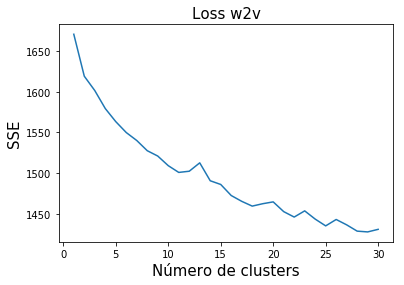

In [12]:
loss_w2v = [data_w2v[K]['loss'] for K in Ks]
plt.plot(np.arange(1, len(loss_w2v) + 1), loss_w2v)
plt.title('Loss w2v', fontsize=15)
plt.ylabel('SSE', fontsize=15)
plt.xlabel('Número de clusters', fontsize=15)
plt.show()

# Verificando Qualidade dos Clusters para K = 29

In [13]:
# loss, medoids, labels = kmeansplusplus(30, data)

K = 29
loss, medoids, labels = data_w2v[K]['loss'], data_w2v[K]['medoids'], data_w2v[K]['labels']

In [14]:
n_closest_neighbors = 3

def get_closest_neighbors(medoid, data, n_closest_neighbors):
    distances = [euclidean(medoid, data_point) for data_point in data]
    closest_idx = np.argsort(distances)[:n_closest_neighbors]
    return closest_idx

positions = []
for label in [1, 4, 17]:
    positions.append(get_closest_neighbors(medoids[label], data, n_closest_neighbors))

In [15]:
for ix, i in enumerate(text['headline_text'].loc[positions[0]].values):
    print('{}: {} \n'.format(ix, i))

0: .@RoscoeTheHorse Not really. But common sense says to avoid anyone who's sick. Virus spreads only when there are symptoms! #EbolaQandA 

1: 1 in 8 U.S. babies is born pre-term. @LIFE takes a look at how hospitals saved these tiny humans 75 yrs ago 

2: RT @CNNVideo: Deaf toddler's reaction to hearing his dad's voice for the first time will make your day. @drsanjaygupta reports: 



In [16]:
for ix, i in enumerate(text['headline_text'].loc[positions[1]].values):
    print('{}: {} \n'.format(ix, i))

0: RT @kellywallacetv: What's the advice when your child wants to stop a physical activity &amp; you know it's good for them to keep doing it? #fi… 

1: . @jillianmichaels shows us 3 simple moves to workout your chest. These can be done from anywhere in a few minutes: 

2: RT @drsanjaygupta: letting @diananyad get some rest, and then I sit down with her for 1st post swim intvu. anything you want me to ask? #ex… 



In [17]:
for ix, i in enumerate(text['headline_text'].loc[positions[2]].values):
    print('{}: {} \n'.format(ix, i))

0: RT @NCADA_STL: @cnnhealth Thanks for the article "What you need to know about synthetic #drugs". Great info for #parents &amp; #kids. 

1: FDA warned docs this week about prescribing too much acetaminophen. 5 things you need to know about this pain killer 

2: Worried about the new virus sweeping the Midwest? Here's what you need to know to keep your kids (&amp; you) healthy: 



# Checking Cluster Quality

In [18]:
# For every cluster, find datapoint nearest to centroid
n_closest_neighbors = 1
closest_datapoints = []
for medoid in medoids:
    closest_datapoints.append(get_closest_neighbors(medoid, data, n_closest_neighbors)[0])
print(closest_datapoints)

[412, 289, 1635, 7087, 1377, 10353, 7863, 412, 7599, 6438, 3568, 564, 8103, 8535, 6438, 8001, 1800, 2000, 6786, 7852, 551, 1111, 6594, 1045, 1459, 455, 8007, 551, 1663]


In [20]:
# For every centroid, find other nearest centroid
n_closest_neighbors = 2
closest_medoids = []
for medoid in medoids:
    closest_medoids.append(get_closest_neighbors(medoid, medoids, n_closest_neighbors)[1])
print(closest_medoids)

[23, 14, 23, 14, 14, 2, 23, 23, 23, 14, 14, 14, 14, 14, 15, 20, 14, 14, 14, 14, 15, 23, 26, 14, 25, 23, 4, 20, 14]


In [21]:
def get_silhouette(datapoint, data_cluster, data_nearest_cluster):
    a = np.mean([euclidean(datapoint, data) for data in data_cluster])
    b = np.mean([euclidean(datapoint, data) for data in data_nearest_cluster])
    return (b - a)/max(a,b)

s_values = np.zeros(len(closest_datapoints))
for k_idx, closest_datapoint in enumerate(closest_datapoints):
    datapoint = data[closest_datapoint]
    data_cluster = data[np.where(labels == k_idx)[0]]
    data_nearest_cluster = data[np.where(labels == closest_medoids[k_idx])[0]]
    s_values[k_idx] = get_silhouette(datapoint, data_cluster, data_nearest_cluster)

print(s_values)

[-0.00121861 -0.13562212 -0.01691333 -0.04498302 -0.05150622  1.
  0.08084083  0.00231184  0.12909847 -0.03105534 -0.03452284  0.08977195
 -0.02226346  0.05492303 -0.08776375  0.12012651 -0.01703004  0.03412159
  0.16361041  0.04712263 -0.00797631  0.11566405  0.46460941 -0.16649668
  0.12784392 -0.05981574  0.09709807 -0.13224763 -0.06680008]


In [22]:
np.mean(s_values)

0.05692853613886127

# PCA

In [113]:
total_variance = 0.95

data_pca = X_w2v - X_w2v.mean(axis=0)

sigma = np.cov(data_pca.T)
u, s, vh = np.linalg.svd(sigma)

def get_list_eigenvalues(sigma, variance):
    variance = variance*np.sum(sigma)
    cur_variance = 0
    n_eigenvalues = 0
    for i in sigma:
        n_eigenvalues += 1
        cur_variance += i
        if (cur_variance >= variance):
            return n_eigenvalues
        
n_eigenvalues = get_list_eigenvalues(s, total_variance)
reduced_u = u[:, 0:n_eigenvalues]

data_pca = np.dot(data_pca, reduced_u)

In [114]:
data_pca.shape

(12791, 115)

In [116]:
K = 29
loss_pca, medoids_pca, labels_pca = kmeansplusplus(K, data_pca)